In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit
import iminuit
import awkward as ak

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [3]:
# plt.style.use('./pylib/cmd1202.mplstyle')

In [4]:
SEASON = '19'
N_MC = 20000

In [5]:
exp_tree = uproot.open(f'../trees/{SEASON}/exp.root')['t']
mc_tree = uproot.open(f'../trees/{SEASON}/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=False, z_cut=12)
df_mc = preprocess.read_tree(mc_tree, mc=True, z_cut=12)

assert np.any( df_exp.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 ) #check energies in df
assert np.any( df_mc.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 )

## Импульс-масса

In [5]:
e = 800
de, dm = df_exp.loc[e], df_mc.loc[e]

In [53]:
rotate_f = lambda e: 0.205/(e*2e-3-0.732) + 0.14
rotate_k = lambda e: np.tan(rotate_f(e))

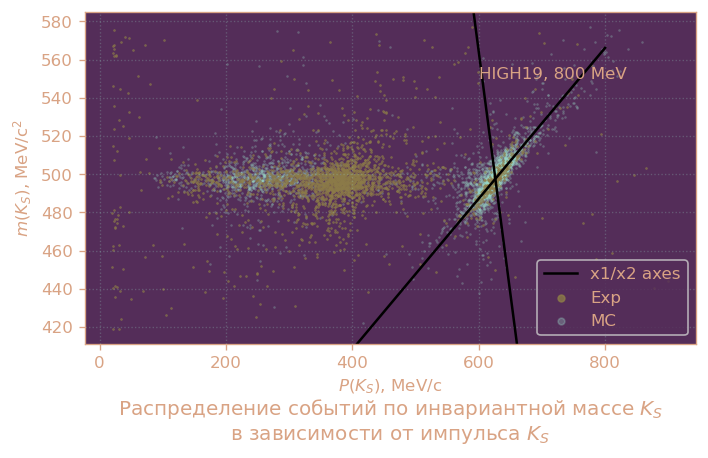

In [69]:
# plt.axes().set_aspect('equal')
plt.scatter(de.ksptot, de.ksminv, marker='.', s=1, alpha=0.8, label='Exp')
plt.scatter(dm.ksptot, dm.ksminv, marker='.', s=1, zorder=-1, alpha=0.3, label='MC')
plt.text(600, 550, f'HIGH19, {e} MeV')
plt.xlabel('$P(K_S)$, MeV/c')
plt.ylabel('$m(K_S)$, MeV/c${}^2$')
plt.ylim(None, None)
plt.title('Распределение событий по инвариантной массе $K_S$\nв зависимости от импульса $K_S$',  y=-0.32)
xx = np.array([400, 800])
plt.plot(xx, rotate_k(800)*(xx-np.sqrt(800**2 - 497.6**2))+497.6, c='black', label='x1/x2 axes')
plt.legend(markerscale=8)
plt.plot(xx, -1/rotate_k(800)*(xx-np.sqrt(800**2 - 497.6**2))+497.6, c='black')
plt.tight_layout()
# plt.savefig('./images/slides/mp_x1x2.png', dpi=160)

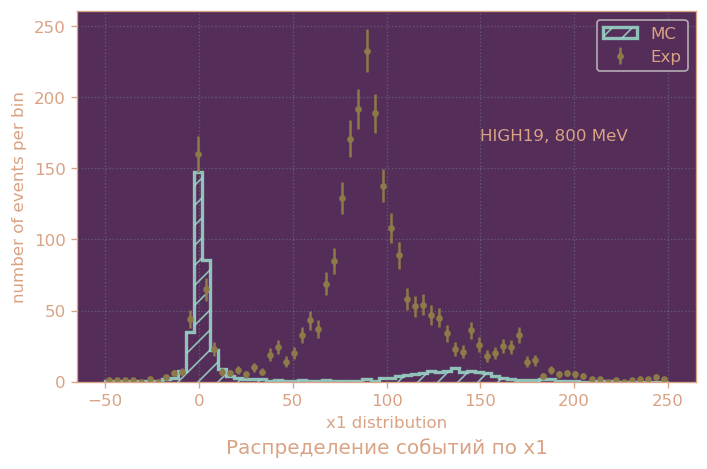

In [99]:
xm = 7
# plt.hist(de.x1, range=(-50, 250), bins=70);
pys.hep_histo(de.x1, range=(-50, 250), bins=70, label='Exp')
plt.hist(dm.x1, range=(-50, 250), weights=np.ones_like(dm.x1)*len(de.query(f'abs(x1)<{xm}'))/len(dm.query(f'abs(x1)<{xm}')), alpha=0.87,
        histtype='step', lw=2, hatch='//', bins=70, label='MC', zorder=-1);
plt.xlabel('x1 distribution');
plt.ylabel('number of events per bin');
plt.legend(markerscale=1)
plt.title('Распределение событий по x1',  y=-0.22)
plt.text(150, 170, f'HIGH19, {e} MeV')
plt.tight_layout()
# plt.savefig('./images/slides/x1.png', dpi=160)

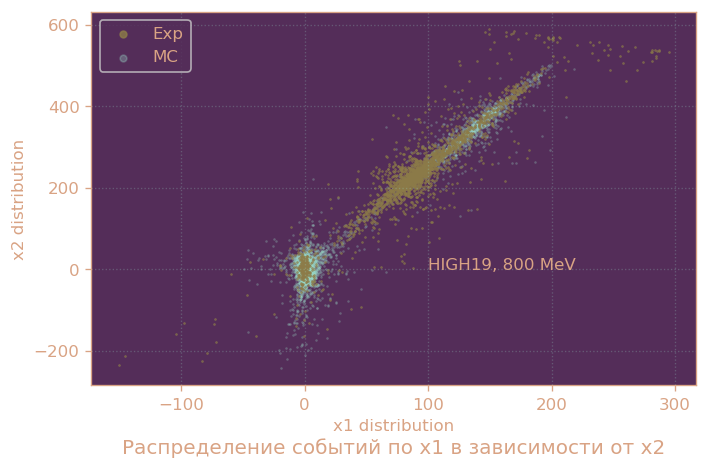

In [103]:
# plt.axes().set_aspect(4)
plt.scatter(de.x1, -de.x2, marker='.', s=1, alpha=0.8, label='Exp')
plt.scatter(dm.x1, -dm.x2, marker='.', s=1, zorder=-1, alpha=0.3, label='MC')
plt.legend(markerscale=8)
# plt.text(600, 550, f'HIGH19, {e} MeV')
plt.xlabel('x1 distribution')
plt.ylabel('x2 distribution')
plt.text(100, 0, f'HIGH19, {e} MeV')
plt.title('Распределение событий по x1 в зависимости от x2',  y=-0.21)
plt.tight_layout()
# plt.savefig('./images/slides/x12.png', dpi=160)

Триггеры

In [6]:
seasons = ['11', '12', '17', '19', '20']
df_t = {season : pd.read_csv(f'../data/{season}/results/triggers.csv', index_col=0) for season in seasons}

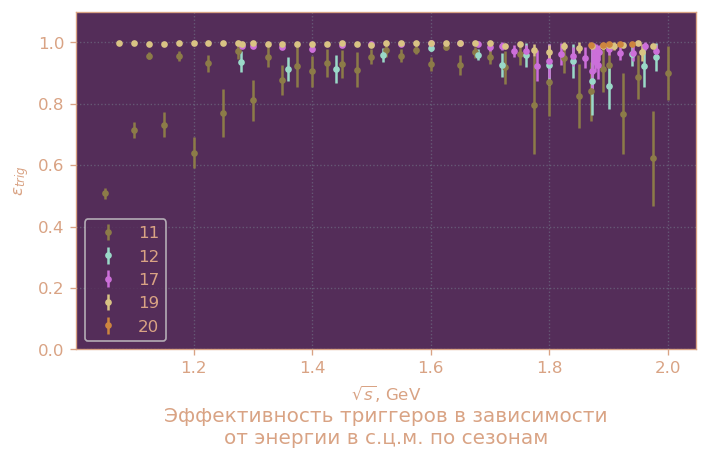

In [26]:
for key in df_t:
    plt.errorbar( df_t[key].index*2e-3, df_t[key].eff_trig, yerr = df_t[key].eff_trig_err, fmt='.', label=key)
plt.ylim(0, 1.1);
plt.xlabel('$\sqrt{s}$, GeV')
plt.ylabel('$\\varepsilon_{trig}$')
plt.title('Эффективность триггеров в зависимости\nот энергии в с.ц.м. по сезонам',  y=-0.31)
plt.legend();
plt.tight_layout()
# plt.savefig('./images/slides/trigs.png', dpi=160)

Reg eff

In [27]:
df_r = {season : pd.read_csv(f'../data/{season}/results/reg_eff.csv', index_col=0) for season in seasons}

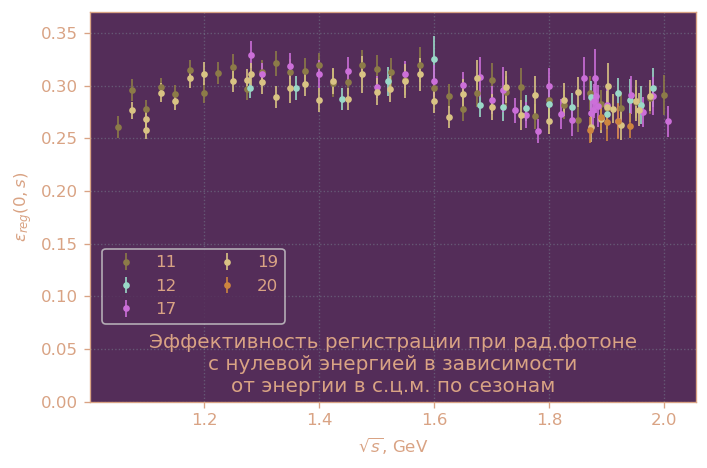

In [58]:
for key in df_t:
    plt.errorbar( df_r[key].index*2e-3, df_r[key].eff0, yerr = df_r[key].eff0_err, fmt='.', label=key, lw=1)
plt.ylim(0, 0.37);
plt.xlabel('$\sqrt{s}$, GeV')
plt.ylabel('$\\varepsilon_{reg}(0, s)$')
plt.title('Эффективность регистрации при рад.фотоне\nс нулевой энергией в зависимости\nот энергии в с.ц.м. по сезонам',  y=-0)
plt.legend(ncol=2, loc=(0.02, 0.2))
plt.tight_layout()
# plt.savefig('./images/slides/effreg.png', dpi=160)

Radcor

In [59]:
df_rad = {season : pd.read_csv(f'../data/{season}/results/radcors.csv', index_col=0) for season in seasons}

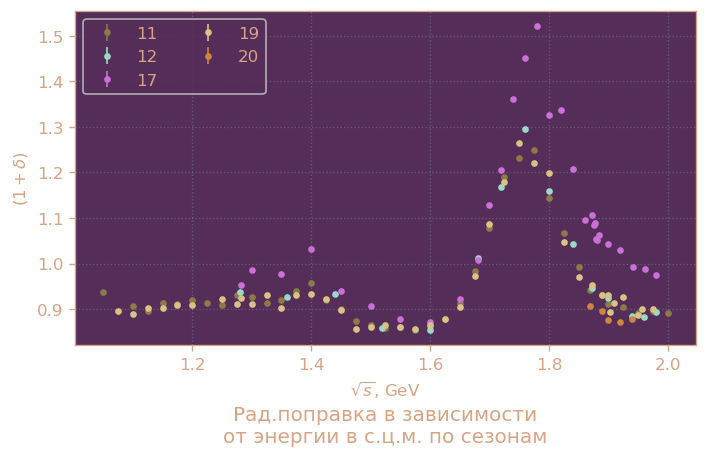

In [69]:
for key in df_rad:
    plt.errorbar( df_rad[key].index*2e-3, df_rad[key].rad, yerr = df_rad[key].rad_err, fmt='.', label=key, lw=1)
# plt.ylim(0, 0.37);
plt.xlabel('$\sqrt{s}$, GeV')
plt.ylabel('$(1+\delta)$')
plt.title('Рад.поправка в зависимости\nот энергии в с.ц.м. по сезонам',  y=-0.32)
plt.legend(ncol=2)
plt.tight_layout()
# plt.savefig('./images/slides/rad.png', dpi=160)

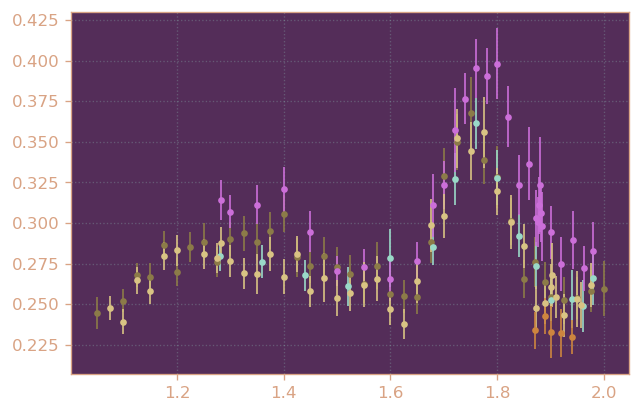

In [75]:
for key in df_rad:
    df_temp = df_rad[key].join(df_r[key])
    df_temp['reff'] = df_temp['rad']*df_temp['eff0']
    plt.errorbar( df_temp.index*2e-3, df_temp.reff, yerr = df_temp.eff0_err*df_temp.rad, fmt='.', label=key, lw=1)

DC

In [ ]:
seasons = ['11', '12', '17', '19', '20']

df_reg = {season : pd.read_csv(f'../data/{season}/results/dc_n2.csv', index_col=0) for season in seasons}

for key in df_reg:
    plt.errorbar(df_reg[key].index*2e-3, df_reg[key].dccorr, 
                 yerr=df_reg[key].dccorr_err, fmt='.', label=key, ms=5, lw=1)
pys.my_style(xtitle='$\\sqrt{s}$, GeV', ytitle='$\\varepsilon_{DC}^{exp}/\\varepsilon_{DC}^{MC}$', legend=True,
            ylim=(0.7, None))
plt.title('Поправки на эффективность ДК', y=-0.22)
plt.grid()
plt.tight_layout()
# plt.savefig('./images/slides/dccorr.png', dpi=160)

In [71]:
df_r['11']

,mu,s,c,N,mu_err,s_err,c_err,N_err,eff0,eff0_err
525.0,0.016293,0.002214,0.034637,0.252151,0.000226,0.000193,0.013153,0.006792,0.260725,0.010323
537.5,0.020522,0.003527,0.007529,0.294736,0.000372,0.000282,0.007909,0.008372,0.296082,0.010455
550.0,0.025946,0.003657,0.011723,0.275017,0.000359,0.000291,0.005728,0.006421,0.278013,0.007977
562.5,0.029131,0.004905,0.003994,0.298200,0.000469,0.000303,0.004542,0.007094,0.298608,0.008257
575.0,0.033082,0.005877,0.009770,0.290183,0.000626,0.000438,0.004866,0.007844,0.291980,0.008984
587.5,0.036201,0.006976,0.005974,0.314537,0.000720,0.000479,0.004140,0.008513,0.314672,0.009379
600.0,0.040613,0.008189,0.006950,0.293124,0.000847,0.000560,0.004594,0.008346,0.293119,0.009216
612.5,0.043351,0.010180,0.003254,0.315572,0.001088,0.000662,0.004191,0.009871,0.312197,0.010356
625.0,0.043601,0.012036,0.002916,0.325212,0.001501,0.000867,0.004185,0.012715,0.317700,0.012679
637.5,0.049163,0.010108,0.008618,0.296239,0.001230,0.000724,0.003895,0.009374,0.296522,0.010027


Картинка dE/dX

In [6]:
t = uproot.open("root://sl10cmd//scan2011/scan2011_tr_ph_fc_e550_v7.root")['tr_ph']

In [7]:
dedx = t.arrays(['tptot', 'tdedx'], cut='(nt>=2)&(abs(tz)<12)&(tchi2z<30)&(tchi2r<25)&(tnhit>6)&(nks==1)')

In [8]:
x, y = ak.to_numpy(ak.flatten(dedx['tptot'])), ak.to_numpy(ak.flatten(dedx['tdedx']))

In [9]:
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

In [10]:
# x = np.where( x < np.quantile(x, 0.9), x, np.quantile(x, 0.96))
# y = np.where( y < np.quantile(y, 0.9), y, np.quantile(y, 0.96))

In [11]:
N = 256
red = np.ones((N, 4))
red[:, 0] = np.linspace(84/256, 219/256, N)
red[:, 1] = np.linspace(45/256, 195/256, N)
red[:, 2] = np.linspace(89/256, 132/256, N)
red_cmp = ListedColormap(red)

In [12]:
#background = #D9A384
#text = #D9C384
#another text = #9AD9C8
#complementary = #8C7B48
#additional = #CC6FD9

In [13]:
cb = '#D9A384'
ctext2 = '#D9C384'
ctext = '#9AD9C8'
c3 = '#8C7B48'
c4 = '#CC6FD9'

In [14]:
plt.rc('axes', facecolor=c3, edgecolor=ctext2,
       axisbelow=True, grid=True)
plt.rc('xtick', direction='out', color=ctext2)
plt.rc('ytick', direction='out', color=ctext2)

In [15]:
f_dedx = lambda P: 5.58030e+9 / (P + 40.)**3 + 2.21228e+3 - 3.77103e-1 * P

In [16]:
xp = np.linspace(40, 600, 100)
yp = f_dedx(xp)

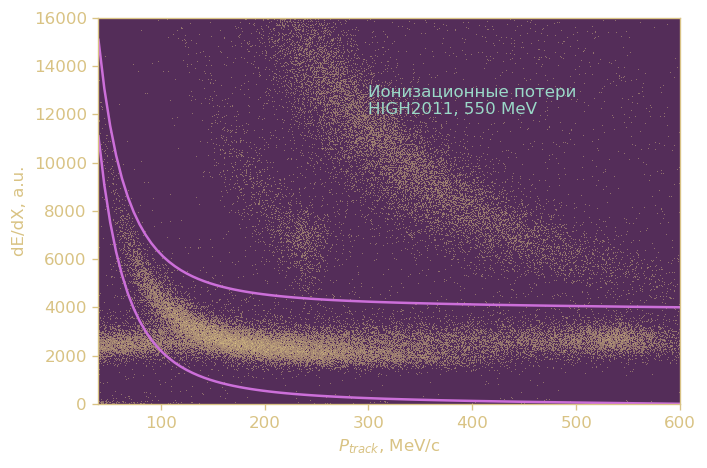

In [22]:
# plt.figure(dpi=160)
plt.hist2d(x, y, bins=(800, 500), range=((40, 600), (0, 16000)), cmap=red_cmp, density=True, norm=mcolors.PowerNorm(0.3))
plt.grid(ls=':', color=c3)
plt.text(300, 12000, 'Ионизационные потери\nHIGH2011, 550 MeV', color=ctext)
plt.plot(xp, yp+2e3, color=c4)
plt.plot(xp, yp-2e3, color=c4)
plt.xlabel('$P_{track}$, MeV/c', color=ctext2)
plt.ylabel('dE/dX, a.u.', color=ctext2)
plt.tight_layout()
# plt.savefig('./images/dedx.png', dpi=160)

## $\alpha$

In [102]:
plt.style.use('./pylib/cmd1202.mplstyle')

In [50]:
SEASON = '19'
exp_tree = uproot.open(f'../trees/{SEASON}/exp.root')['t']
mc_tree = uproot.open(f'../trees/{SEASON}/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=False, z_cut=12, align_cut=None)
df_mc = preprocess.read_tree(mc_tree, mc=True, z_cut=12, align_cut=None)

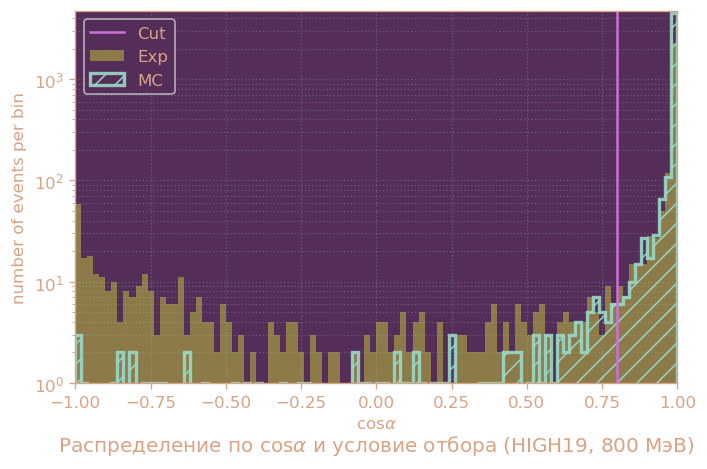

In [116]:
plt.hist(df_exp.loc[800].ksalign, bins=100, range=(-1, 1), label='Exp', zorder=1, alpha=1);
plt.hist(df_mc.loc[800].ksalign, bins=100, range=(-1, 1), label='MC', alpha=0.9, histtype='step', lw=2, hatch='//');
plt.ylabel('number of events per bin')
# plt.grid(alpha=0.)
plt.xlabel('$\\cos{\\alpha}$')
plt.xlim((-1, 1))
plt.ylim(1, None)
plt.title('Распределение по $\\cos{\\alpha}$ и условие отбора (HIGH19, 800 MэВ)',  y=-0.21)
plt.plot([0.8, 0.8], [0, 1e6], label='Cut')
plt.legend(loc='upper left')
plt.yscale('log');
plt.tight_layout();
# plt.savefig('./images/alpha.png', dpi=160, pad_inches=0)

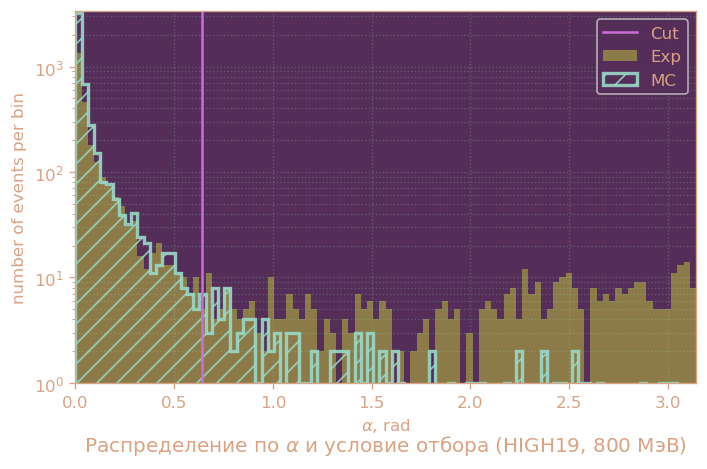

In [125]:
plt.hist(np.arccos(df_exp.loc[800].ksalign), bins=100, range=(0, np.pi), label='Exp', zorder=1, alpha=1);
plt.hist(np.arccos(df_mc.loc[800].ksalign), bins=100, range=(0, np.pi), label='MC', alpha=0.9, histtype='step', lw=2, hatch='//');
plt.ylabel('number of events per bin')
# plt.grid(alpha=0.)
plt.xlabel('$\\alpha$, rad')
plt.xlim(0, np.pi)
plt.ylim(1, None)
plt.title('Распределение по $\\alpha$ и условие отбора (HIGH19, 800 MэВ)',  y=-0.21)
plt.plot(np.arccos(np.array([0.8, 0.8])), [0, 1e6], label='Cut')
plt.legend(loc='upper right')
plt.yscale('log');
plt.tight_layout();
# plt.savefig('./images/alpha_angle.png', dpi=160, pad_inches=0)

Lum

In [10]:
import pandas as pd
seasons = ['11', '12', '17', '19', '20']
dd = pd.Series(data=0, index=['lum'])
for season in seasons:
    dd += pd.read_csv(f'/storeA/ryzhenenkov/lum20{season}.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy').sum()

In [11]:
dd

lum    193159.94191
dtype: float64

____
## Fit part

In [9]:
energies_list = df_exp.index.unique().intersection(df_mc.index.unique())
for i in sorted(energies_list):
    print(i, end=' ')
it = iter(energies_list)

537.5 550.0 562.5 575.0 587.5 600.0 612.5 625.0 637.5 641.0 650.0 662.5 675.0 687.5 700.0 712.5 725.0 737.5 750.0 762.0 775.0 787.5 800.0 812.5 825.0 837.5 850.0 862.5 875.0 887.5 900.0 912.5 925.0 936.0 945.0 950.0 951.1 955.0 962.5 975.0 978.0 987.5 

[$\chi^2$-calculator](https://www.di-mgt.com.au/chisquare-calculator.html)

In [10]:
fit_range = (-40, 20)
hist_range = (-40, 40)
width = fit_range[1] - fit_range[0]

params = {
    'n_sig': (2000, (0.1, None)),
#     'n_bkg': (  10, (0, None)),  
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
#     'k'    : ( 0.1, (None, None)),
    'y0'   : (   0, (0, None)),
    'y1'   : (   0, (0, None)),
}

In [11]:
def get_x1(df_exp, df_mc, e0):
    dfE = df_exp.loc[e0].copy()
    dfM =  df_mc.loc[e0].copy()
    assert dfM.runnum.nunique()==1
    return dfE, dfM
    
def get_params_exp(params, m_mc, non_limited=['n_sig', 'n_bkg', 'k']):
    params_exp = params.copy()
    for k in m_mc.parameters:
        params_exp[k] = ( m_mc.values[k], params_exp[k][1] )
        if k not in non_limited:
            mean, std = m_mc.values[k], 2*m_mc.errors[k]
            params_exp[k] = ( m_mc.values[k],(mean-std, mean+std) )
    return params_exp

In [12]:
e0 = next(it)
print(f'Energy {e0} MeV')

Energy 537.5 MeV


In [13]:
dfE, dfM = get_x1(df_exp, df_mc, e0)
dataE, dataM = dfE.x1.values, dfM.x1.values
dataE, dataM = dataE[(dataE>-40)&(dataE<20)], dataM[(dataM>-40)&(dataM<20)]

In [14]:
import numba as nb
from scipy.integrate import quad
@nb.njit(parallel=False, fastmath=True)
def cruijff(x, m, sL, sR, aL, aR):
    denom = 2*np.where(x<m, (sL**2 + aL*(x-m)**2), (sR**2 + aR*(x-m)**2) )
    return np.exp(-(x-m)**2/denom)

def cruijff_norm(x, m, sL, sR, aL, aR, fit_range):
    xmin, xmax = fit_range
    I = quad(cruijff, xmin, xmax, args=(m, sL, sR, aL, aR))[0]
    return cruijff(x, m, sL, sR, aL, aR)/I

def linear(x, y0, y1, fit_range):
    xmin, xmax = fit_range
    return (y1 - y0)*(x - xmin)/(xmax - xmin) + y0

In [15]:
pdf = lambda x, n_sig, m, sL, sR, aL, aR, y0, y1: \
( n_sig + width*(y0+y1)/2, n_sig*cruijff_norm(x, m, sL, sR, aL, aR, fit_range) + linear(x, y0, y1, fit_range))

In [36]:
costF = iminuit.cost.ExtendedUnbinnedNLL(dataE, pdf, verbose=0)
costN = iminuit.cost.NormalConstraint('m', 0, 0.1)
costF = costF + costN

In [37]:
parameters = {k : params[k][0] for k in params}
m = iminuit.Minuit(costF, **parameters)
for par in m.parameters:
    m.limits[par] = params[par][1]

In [38]:
m.migrad().hesse()#.minos()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.547e+04                 │              Nfcn = 757              │
│ EDM = 2.63e-05 (Goal: 0.1)       │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_sig │  2.18e3   │  0.06e3   │            │            │   0.1   │         │       │
│ 1 │ m     │   0.00    │   0.09    │            │            │   -5    │    5    │       │
│ 2 │ sL    │   3.02    │   0.12    │            │            │    1    │   10    │       │
│ 3 │ sR    │   2.70    │   0.15    │            │            │    1    │   10    │       │
│ 4 │ aL    │   0.088   │   0.004   │            │            │    0    │   10    │       │
│ 5 │ aR    │   0.147   │   0.009   │            │            │    0    │   10    │       │
│ 6 │ y0    │    0.0    │    0.6    │            │            │    0    │         │       │
│ 7 │ y1    │     0     │     4     │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────┐
│       │     n_sig         m        sL        sR        aL        aR        y0        y1 │
├───────┼─────────────────────────────────────────────────────────────────────────────────┤
│ n_sig │  3.49e+03     0.132      0.13    -0.465    0.0965     0.181  -0.00317     0.356 │
│     m │     0.132   0.00899   0.00501  -0.00665 -5.22e-05  0.000164  1.54e-06  3.59e-05 │
│    sL │      0.13   0.00501    0.0139  0.000825 -0.000207  9.15e-05   8.7e-06  3.55e-05 │
│    sR │    -0.465  -0.00665  0.000825    0.0233 -2.01e-06 -0.000705  4.25e-07 -0.000126 │
│    aL │    0.0965 -5.22e-05 -0.000207 -2.01e-06  1.95e-05  1.24e-05 -8.81e-07  2.62e-05 │
│    aR │     0.181  0.000164  9.15e-05 -0.000705  1.24e-05  7.41e-05 -9.18e-08  4.93e-05 │
│    y0 │  -0.00317  1.54e-06   8.7e-06  4.25e-07 -8.81e-07 -9.18e-08  2.99e-05 -1.96e-07 │
│    y1 │     0.356  3.59e-05  3.55e-05 -0.000126  2.62e-05  4.93e-05 -1.96e-07  9.66e-05 │
└───────┴─────────────────────────────────────────────────────────────────────────────────┘

In [39]:
m.values['n_sig']

2178.9419560540346

In [40]:
m.errors['n_sig']**2

3487.990351308618

In [30]:
nb = width*( m.values['y0'] + m.values['y1'] )/2
nb_err = width*np.sqrt( m.errors['y0'] + m.errors['y1'] )/2
nb, nb_err

(5.933107131594895e-05, 64.02807647257156)

In [74]:
# for par in m_exp.parameters:
#     m_exp.fixed[par] = True if par not in ['n_sig'] else False

In [75]:
print(f' MC: {m_mc.values["n_sig"]:8.2f}, {m_mc.errors["n_sig"]**2:8.2f}')
print(f'Exp: {m_exp.values["n_sig"]:8.2f}, {m_exp.errors["n_sig"]**2:8.2f}')

 MC:  1424.22,  1424.44
Exp:   148.59,   181.85


,n_sig_exp,n_bkg_exp,n_sig_mc
587.5,411.909106,1.608685e+01,1778.055228
600.0,301.673713,5.326212e+00,1661.877620
612.5,198.841108,2.015876e+01,1613.052592
625.0,223.998968,4.520916e-08,1513.155750
637.5,148.588088,4.411990e+00,1424.219393


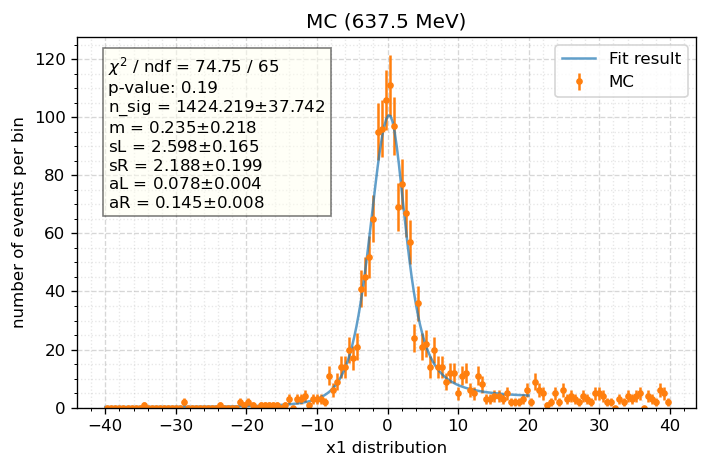

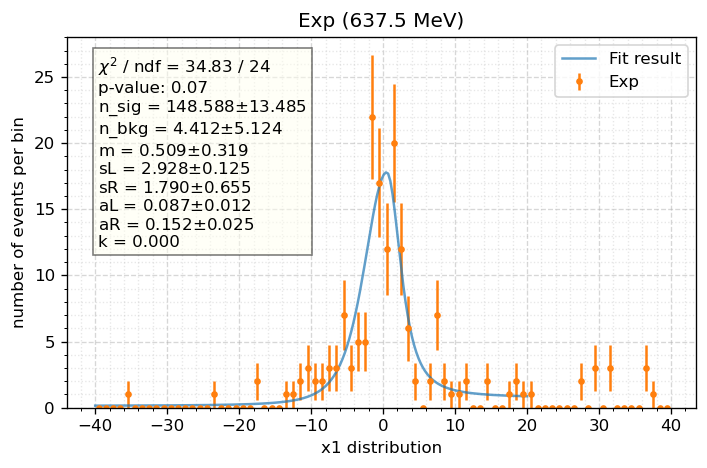

In [76]:
#Plot and save data

def plot_fit_data(save=True):
    pys.plot_fit(dataM, cost_mc, m_mc, 140, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'MC ({e0} MeV)', description=True)
    if save:
        if not(os.path.isdir(f'images/fit{SEASON}')):
            os.mkdir(f'images/fit{SEASON}')
        plt.savefig(f'images/fit{SEASON}/mc_{e0}.png', dpi=120)

    pys.plot_fit(dataE, cost_exp, m_exp, 80, hist_range, fit_range, errors=True, label='Exp', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'Exp ({e0} MeV)', description=True)
    if save:
        plt.savefig(f'images/fit{SEASON}/exp_{e0}.png', dpi=120)

plot_fit_data(save=True)

if 'res_df' not in locals():
    def add_postfix(arr, post):
        return [f'{_}_{post}' for _ in arr]
    cols = add_postfix(m_exp.parameters, 'exp') + add_postfix(m_exp.parameters, 'exp_err') + \
        add_postfix(m_mc.parameters, 'mc') + add_postfix(m_mc.parameters, 'mc_err') + ['emeas']
    res_df = pd.DataFrame(columns=cols)
    del cols
temp_ser = pd.Series(list(m_exp.values) + list(m_exp.errors) + 
                     list(m_mc.values) + list(m_mc.errors) + [dfE.emeas.mean()], index=res_df.columns, name=e0)
if temp_ser.name in res_df.index:
    res_df.drop(temp_ser.name, axis=0, inplace=True)
res_df = res_df.append(temp_ser)
del temp_ser

res_df[['n_sig_exp', 'n_bkg_exp', 'n_sig_mc']].tail()

In [11]:
df1 = pd.read_csv('../data/20/results/signal_old.csv', index_col=0)
df2 = pd.read_csv('../data/20/results/signal.csv', index_col=0)

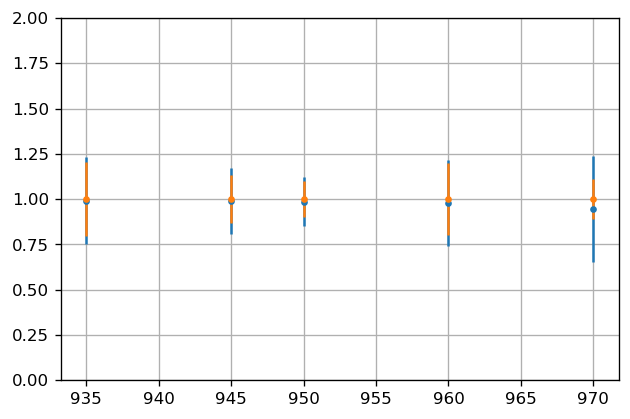

In [12]:
plt.errorbar(df1.index, df2['n_sig_exp']/df1['n_sig_exp'], yerr=df2['n_sig_exp_err']/df1['n_sig_exp'], fmt='.')
plt.errorbar(df1.index, df1['n_sig_exp']/df1['n_sig_exp'], yerr=df1['n_sig_exp_err']/df1['n_sig_exp'], fmt='.')
plt.ylim(0, 2)
plt.grid()

Сравнить v7 vs v8

In [18]:
root7 = uproot.open('../trees/11/exp.root')['t']
root8 = uproot.open('../trees/11/exp_v8.root')['t']

In [8]:
tree7 = preprocess.read_tree(root7).loc[550]

In [19]:
tree8 = preprocess.read_tree(root8).loc[550]

In [33]:
tree7.query('abs(x1)<20').x1.std()

6.755006704014602

In [34]:
tree8.query('abs(x1)<20').x1.std()

6.466508388519287

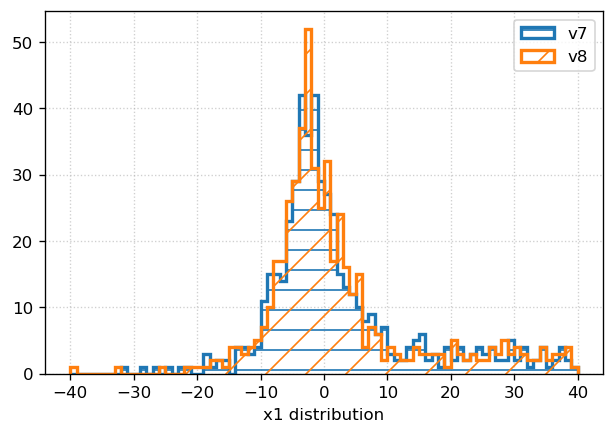

In [32]:
plt.hist(tree7.x1, range=(-40, 40), bins=80, label='v7', histtype='step', lw=2, hatch='-');
plt.hist(tree8.x1, range=(-40, 40), bins=80, label='v8', histtype='step', lw=2, hatch='/');
plt.legend()
plt.xlabel('x1 distribution')
plt.grid(ls=':', alpha=0.6);

In [51]:
def get_x1(df_exp, df_mc, e0):
    dfE = df_exp.loc[e0].copy()
    dfM =  df_mc.loc[e0].copy()
    assert dfM.runnum.nunique()==1
    return dfE, dfM

def get_params_exp(params, m_mc, non_limited=['n_sig', 'n_bkg', 'k']):
    params_exp = params.copy()
    for k in m_mc.parameters:
        params_exp[k] = ( m_mc.values[k], params_exp[k][1] )
        if k not in non_limited:
            mean, std = m_mc.values[k], 52*m_mc.errors[k]
            params_exp[k] = ( m_mc.values[k],(mean-std, mean+std) )
    return params_exp

In [63]:
fit_range = (-40, 20)
params = {
    'n_sig': (2000, (0.1, None)),
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
    'y0'   : (   0.1, (0, None)),
    'dy'   : (   0.1, (0, None)),
}

dfE, dfM = tree7, tree8
dataE, dataM = dfE.x1.values, dfM.x1.values

m_mc, cost_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
m_mc.simplex().migrad(iterate=20).hesse();
params_exp = get_params_exp(params, m_mc, ['n_sig', 'y0', 'y1', 'm'])
params_exp['dy'] = (0, (0, 0))
params_exp['y0'] = (0, (0, None))
m_mc, cost_mc = pyfit.fitter(dataM, fit_range, params_exp, mc=False)
m_mc.simplex().migrad(iterate=20).hesse();
m_exp, cost_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
m_exp.simplex().migrad(iterate=20).migrad().migrad().hesse();

In [74]:
def plot_fit_data(save=True):
    pys.plot_fit(dataM, cost_mc, m_mc, 120, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution', alpha=0.8,
               ytitle='number of events per bin', title=f'v7 ({e0} MeV)', description=True)#, bbox_color=None, fit_color='#CC6FD9', data_color='#9AD9C8')
#     plt.grid(ls=':', alpha=0.2)
    pys.plot_fit(dataE, cost_exp, m_exp, 120, hist_range, fit_range, errors=True, label='Exp', xtitle='x1 distribution', alpha=0.8,
               ytitle='number of events per bin', title=f'v8 ({e0} MeV)', description=True, fill_errors=False)#, fit_color='red', data_color='green')
#     plt.grid(alpha=0.2)

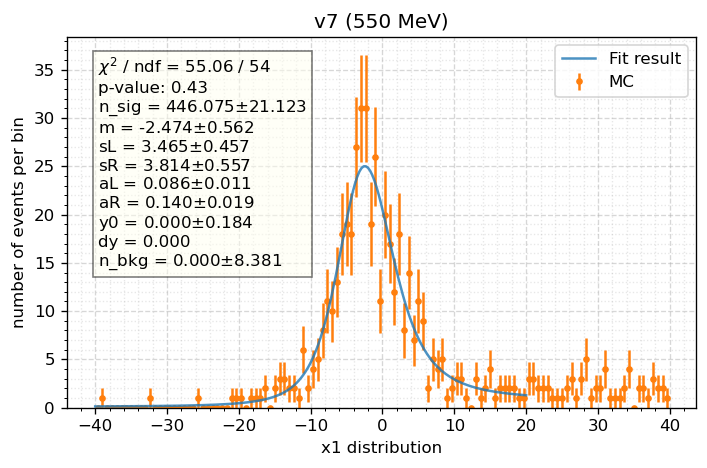

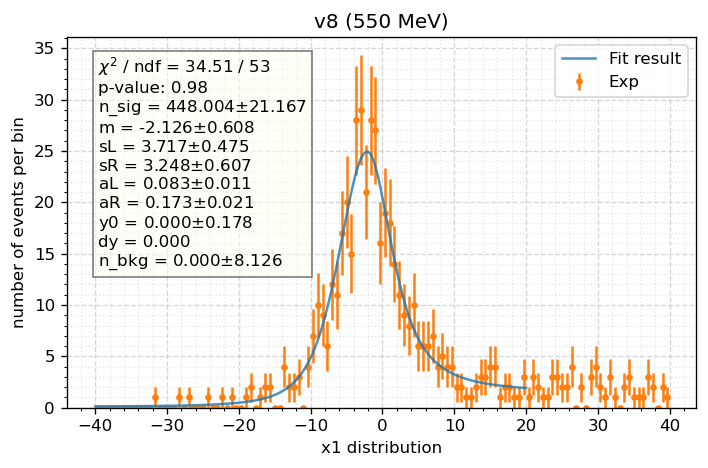

In [75]:
hist_range=(-40, 40)
e0 = 550
plot_fit_data(False)